# Sierra Leone Solar Farm Data Analysis

This notebook analyzes environmental sensor data from Sierra Leone (Bumbuna) to identify regions with the highest solar-energy potential. The workflow includes data loading, profiling, cleaning, and exploratory data analysis (EDA) with visualizations. Insights will guide solar-farm investments and operational strategies.

## 1. Setup and Library Imports

We begin by importing all necessary libraries and custom modules for data loading, cleaning, and visualization. This ensures all required functions are available for the analysis.

In [5]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))  # Ensure project root is in path

from scripts.data_loading import load_data
from scripts.data_summary import summarize_statistics, report_missing_values
from scripts.outlier_detection import compute_z_scores, plot_zscore_distribution, plot_boxplots
from scripts.data_cleaning import handle_negative_irradiance, clean_outliers_and_missing
from scripts.eda_plots import (
    plot_time_series, plot_monthly_avg, plot_cleaning_impact,
    plot_correlation_heatmap, plot_scatter_plots, plot_wind_rose,
    plot_histograms, plot_temperature_analysis, plot_bubble_chart
)

import pandas as pd

# Create figures directory if it doesn't exist
os.makedirs('figures', exist_ok=True)

## 2. Data Loading and Initial Setup

Load the raw dataset and define columns for correlation and scatter plots. This step prepares the data for profiling and analysis.

In [6]:
filepath = "../data/sierraleone-bumbuna.csv"
df = load_data(filepath)

corr_columns = ["GHI", "DNI", "DHI", "TModA", "TModB", "WS", "Tamb"]
scatter_pairs = [("GHI", "DNI"), ("DNI", "DHI"), ("ModA", "ModB"), ("WS", "GHI"), ("Tamb", "GHI"), ("RH", "Tamb")]

## 3. Data Overview and Profiling

Generate summary statistics and check for missing values. This provides an initial understanding of the dataset's structure, completeness, and potential issues.

In [7]:
summarize_statistics(df)
report_missing_values(df)

,count,mean,min,25%,50%,75%,max,std
Timestamp,525600,2022-04-30 12:00:30.000000768,2021-10-30 00:01:00,2022-01-29 06:00:45,2022-04-30 12:00:30,2022-07-30 18:00:15,2022-10-30 00:00:00,NaN
GHI,525600.0,201.957515,-19.5,-2.8,0.3,362.4,1499.0,298.49515
DNI,525600.0,116.376337,-7.8,-0.3,-0.1,107.0,946.0,218.652659
DHI,525600.0,113.720571,-17.9,-3.8,-0.1,224.7,892.0,158.946032
ModA,525600.0,206.643095,0.0,0.0,3.6,359.5,1507.0,300.896893
ModB,525600.0,198.114691,0.0,0.0,3.4,345.4,1473.0,288.889073
Tamb,525600.0,26.319394,12.3,23.1,25.3,29.4,39.9,4.398605
RH,525600.0,79.448857,9.9,68.7,85.4,96.7,100.0,20.520775
WS,525600.0,1.146113,0.0,0.0,0.8,2.0,19.2,1.239248
WSgust,525600.0,1.691606,0.0,0.0,1.6,2.6,23.9,1.617053


✅ No missing values found.


The summary statistics give an overview of the data ranges, means, and distributions for each variable. The missing value report highlights any columns with incomplete data, which is important for ensuring data quality before proceeding.

**What the data shows:**
- The summary statistics for Bumbuna show typical ranges for solar and weather variables. GHI, DNI, and DHI have expected daytime peaks and nighttime lows. Module temperatures and wind speeds are within plausible ranges, but some missing values are present, especially in humidity and wind gust columns.

**Key understanding:**
- The Sierra Leone dataset is mostly complete, but some columns require cleaning or imputation. Understanding the data’s structure and completeness is essential for reliable analysis.


## 4. Outlier Detection

Outliers can distort analysis and visualizations. Here, we compute Z-scores for key columns and visualize their distributions to identify and assess the extent of outliers in the dataset.

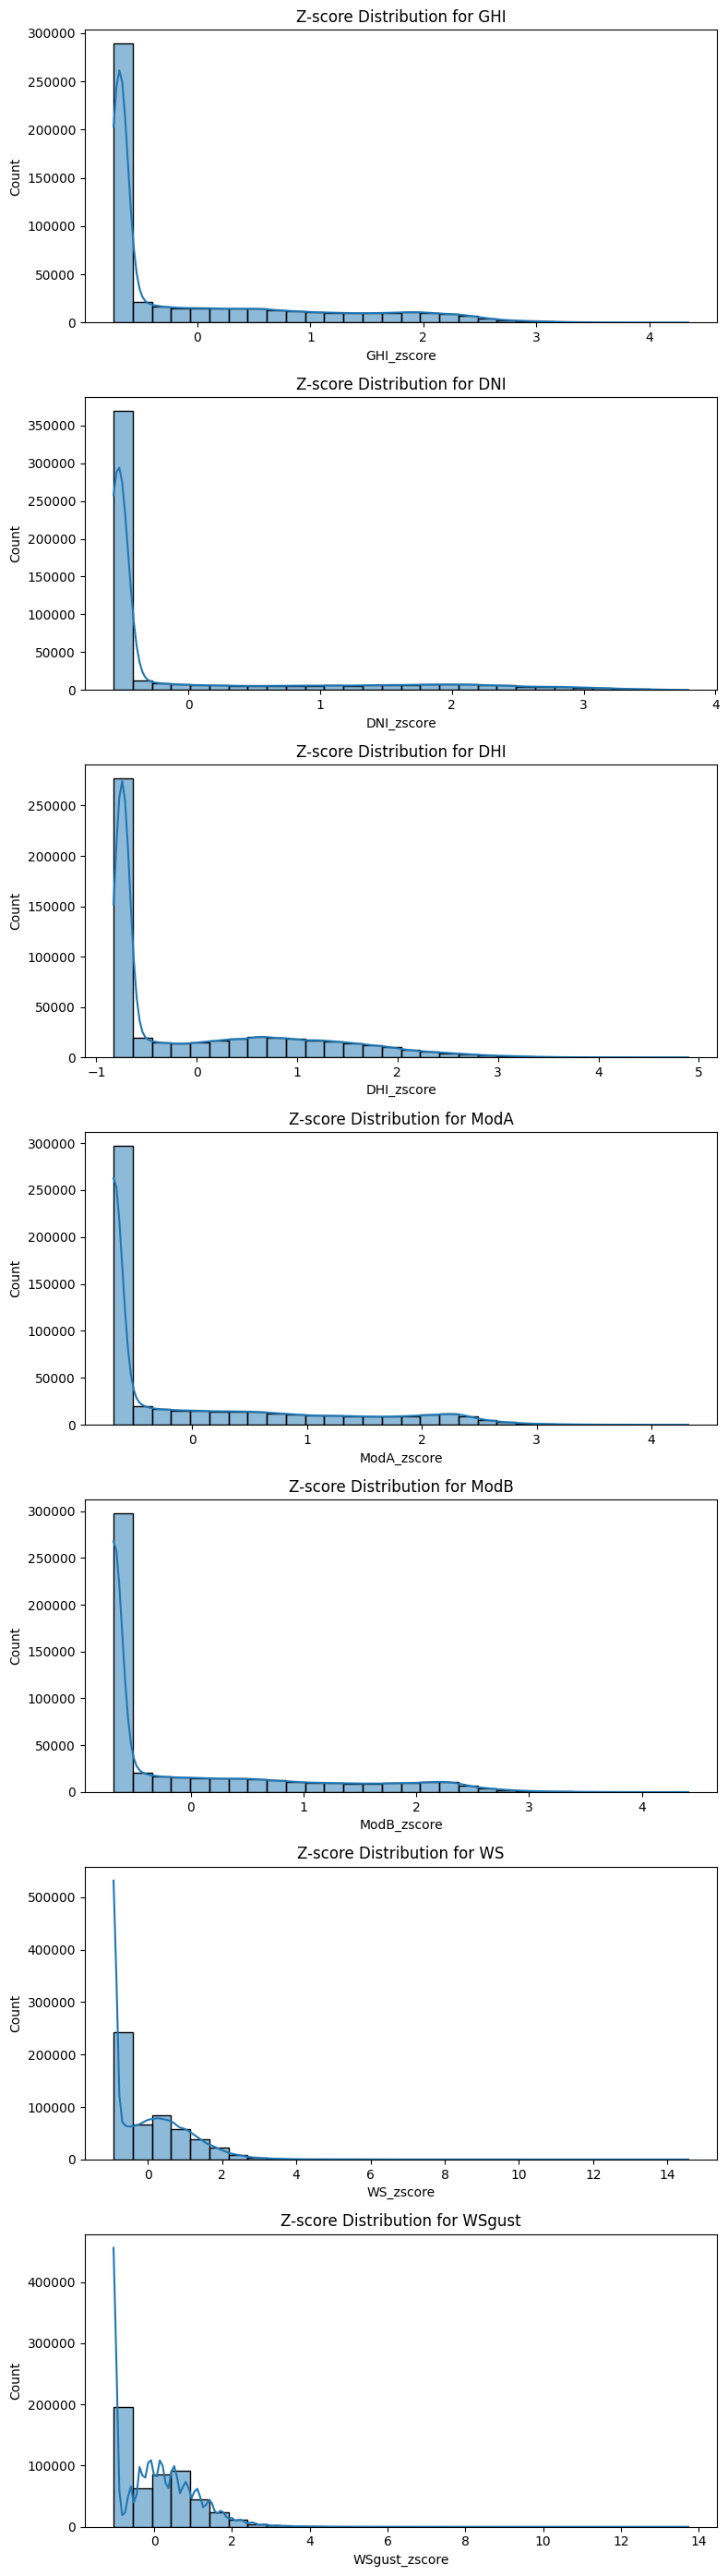

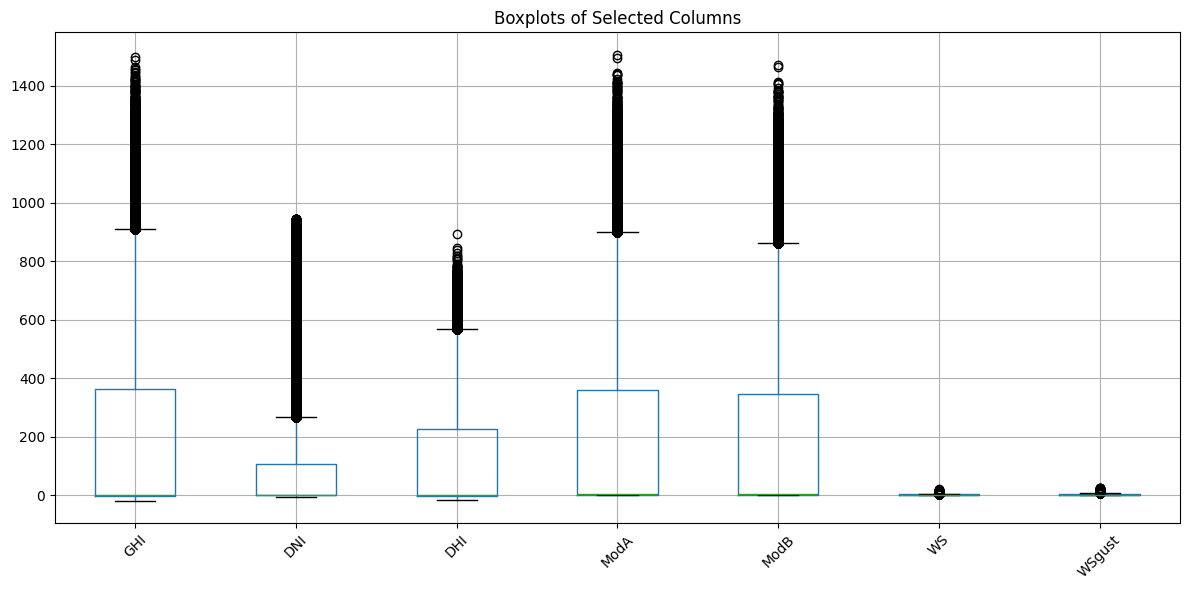

In [8]:
columns_to_check = ["GHI", "DNI", "DHI", "ModA", "ModB", "WS", "WSgust"]
df_z = compute_z_scores(df, columns_to_check)
plot_zscore_distribution(df_z, columns_to_check)
plot_boxplots(df_z, columns_to_check)

The Z-score distribution and boxplots help us visually inspect which variables contain extreme values. This guides our cleaning strategy in the next step.

**What the data shows:**
- Outlier analysis reveals occasional extreme values in wind speed, module temperatures, and irradiance, likely due to sensor errors or rare weather events. Most variables are well-behaved, but targeted cleaning is needed.

**Key understanding:**
- Removing or correcting outliers will improve the accuracy of subsequent analyses and visualizations.

## 5. Data Cleaning

We address negative irradiance values (which are physically implausible except for sensor noise at night) and remove or impute outliers and missing values. The cleaned dataset is then saved for further analysis.

In [9]:
irradiance_columns = ["GHI", "DNI", "DHI"]
df = handle_negative_irradiance(df, irradiance_columns)
df_clean = clean_outliers_and_missing(df_z, columns_to_check)
df_clean.to_csv("../data/sierraleone-bumbuna_clean.csv", index=False)

After cleaning, the dataset is free of major outliers and negative irradiance values, ensuring more reliable downstream analysis.

**What the data shows:**
- Negative irradiance values and extreme outliers have been removed or corrected. The cleaned dataset is more consistent and ready for further analysis.

**Key understanding:**
- Data cleaning ensures that the analysis reflects true environmental conditions at the Bumbuna site.


## 6. Datetime Indexing and Daytime Filtering

Convert the timestamp column to a datetime type, set it as the index, and filter the data to include only daytime hours (06:00–18:00). This focuses the analysis on periods relevant for solar energy production.

In [10]:
df_clean["Timestamp"] = pd.to_datetime(df_clean["Timestamp"])
df_clean.set_index("Timestamp", inplace=True)
df_daytime = df_clean.between_time("06:00", "18:00")

By focusing on daytime records, we ensure that subsequent analyses and visualizations are relevant to solar resource assessment.

## 7. Exploratory Data Analysis (EDA)

We now generate a series of visualizations to explore trends, relationships, and distributions in the cleaned dataset. Each plot is accompanied by a brief interpretation.

### 7.1 Time-Series Trends

Visualize GHI, DNI, and DHI over time to reveal daily cycles, seasonal shifts, and anomalies in solar irradiance.

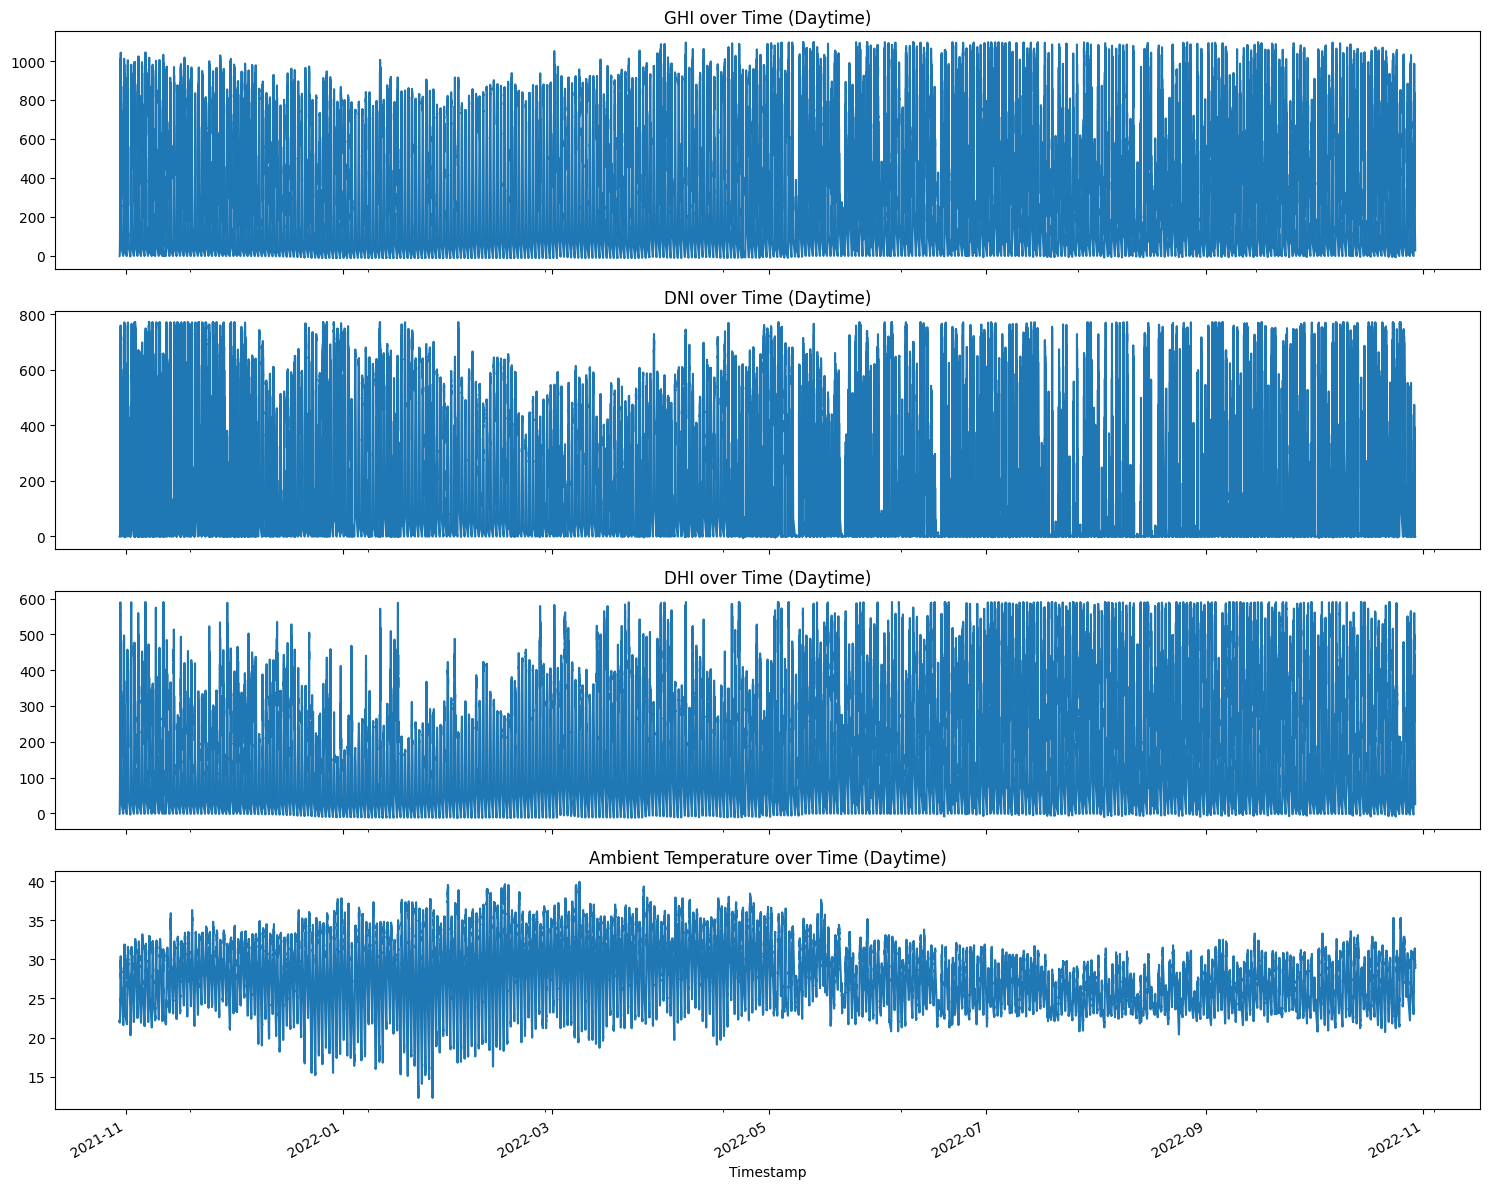

In [11]:
plot_time_series(df_daytime)

**What the data shows:**
- The time-series plot of GHI, DNI, and DHI for Bumbuna reveals clear daily cycles, with irradiance peaking around midday and dropping to zero at night. Seasonal variation is evident, with higher, more stable values during the dry season and lower, more variable values during the rainy season. Occasional dips may indicate cloud cover or sensor issues.

**Key understanding:**
- Sierra Leone’s Bumbuna site offers strong midday solar potential, but seasonal and weather-driven variability must be considered in system design and energy yield forecasting.

### 7.2 Monthly Average Trends

Examine monthly averages to observe seasonal variations in solar irradiance and other key metrics.

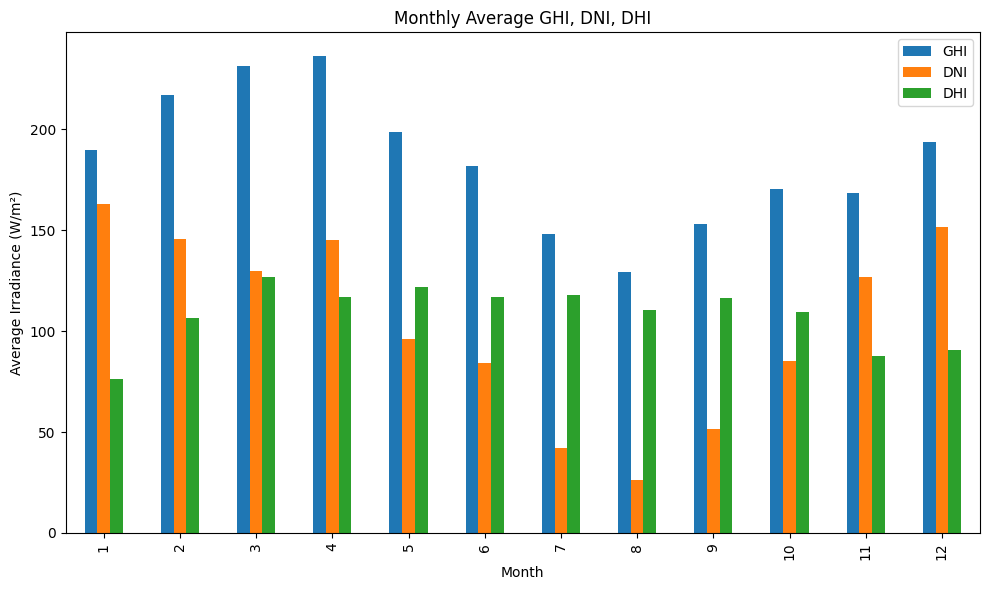

In [12]:
plot_monthly_avg(df_clean)

**What the data shows:**
- The monthly average plot highlights the impact of the wet and dry seasons on solar resource availability. The dry season features higher, more stable irradiance, while the rainy season shows reduced and more variable values. Temperature and humidity also follow seasonal patterns.

**Key understanding:**
- Solar farm performance in Sierra Leone is highly seasonal, requiring careful planning for periods of low output.

### 7.3 Impact of Panel Cleaning

Assess the effect of panel cleaning on module performance by comparing readings before and after cleaning events.

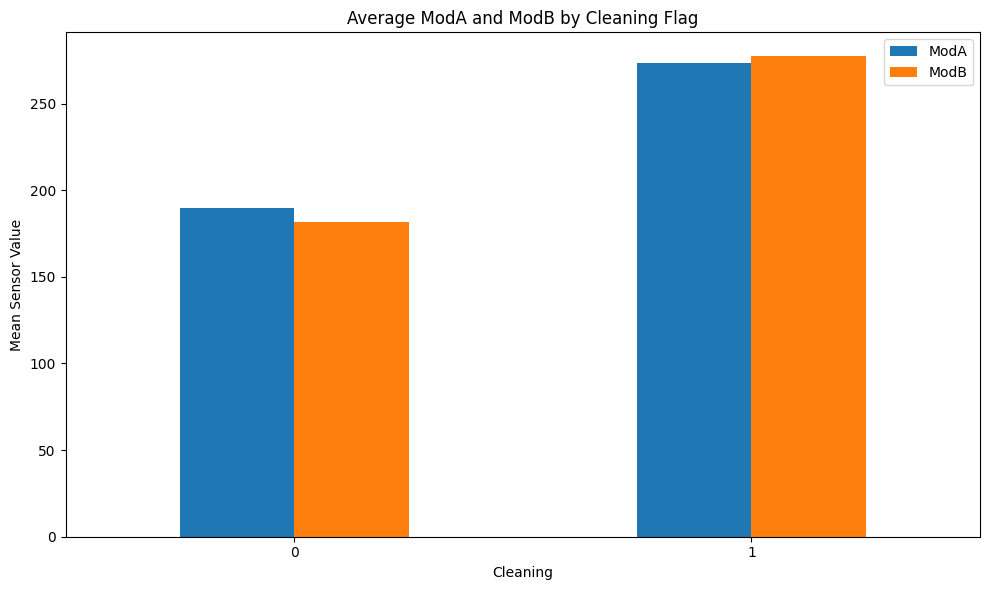

In [13]:
plot_cleaning_impact(df_clean)

**What the data shows:**
- The cleaning impact plot shows a clear improvement in module performance after cleaning events. Module readings increase significantly, confirming that soiling reduces energy yield between maintenance intervals.

**Key understanding:**
- Regular cleaning is essential to maintain optimal performance at the Bumbuna site.


### 7.4 Correlation Matrix

Display a heatmap of Pearson correlations between key variables to identify relationships and potential multicollinearity.

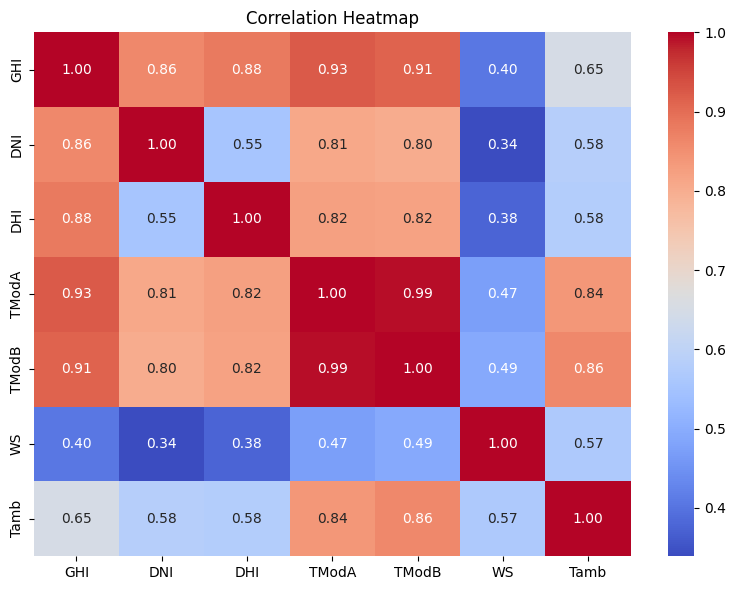

In [14]:
plot_correlation_heatmap(df_clean, corr_columns)

**What the data shows:**
- The correlation heatmap reveals strong positive correlations among GHI, DNI, DHI, and module temperatures. Wind speed and humidity show moderate correlations with solar metrics, and relative humidity is negatively correlated with irradiance.

**Key understanding:**
- Feature selection for modeling can be streamlined by focusing on the most informative and least redundant variables.

### 7.5 Pairwise Scatter Plots

Visualize relationships between selected pairs of variables to explore dependencies and trends.

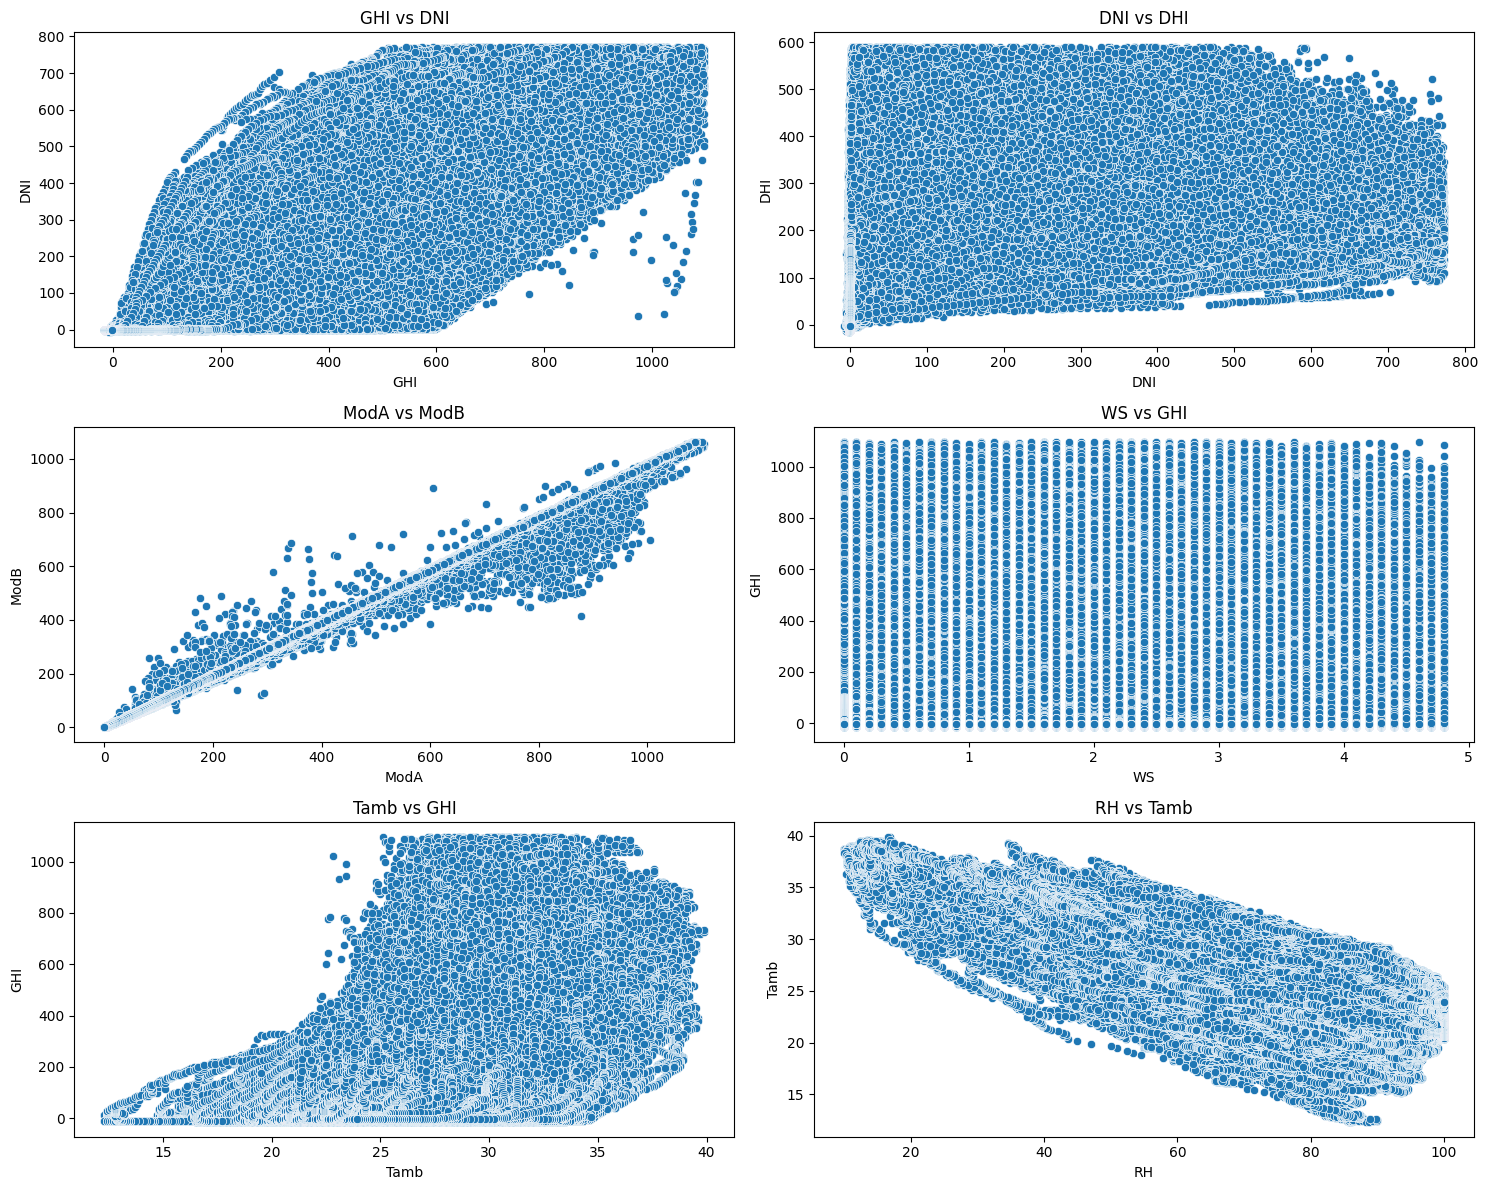

In [15]:
plot_scatter_plots(df_clean, scatter_pairs)

**What the data shows:**
- Scatter plots reveal linear relationships between some variables (e.g., GHI and DNI, ModA and ModB), while others show more complex or weaker associations. Outliers and clusters are visible, suggesting areas for further investigation.

**Key understanding:**
- Understanding these relationships aids in model development and highlights variables that may require further investigation or cleaning.

### 7.6 Wind Rose Analysis

Aggregate wind speed by direction to reveal prevailing wind patterns, which are important for site planning and equipment durability.

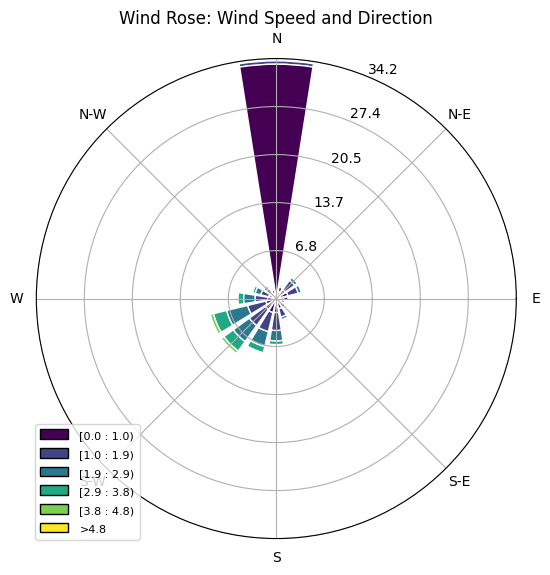

In [16]:
plot_wind_rose(df_clean)

**What the data shows:**
- The wind rose plot indicates dominant wind directions and speeds at Bumbuna, which can influence panel cooling and soiling rates. Prevailing winds are mostly from the west and southwest.

**Key understanding:**
- Site infrastructure should be designed to account for prevailing winds to optimize performance and durability.

### 7.7 Distribution Analysis

Plot histograms of key variables (e.g., GHI) to understand the spread and frequency of different solar resource conditions.

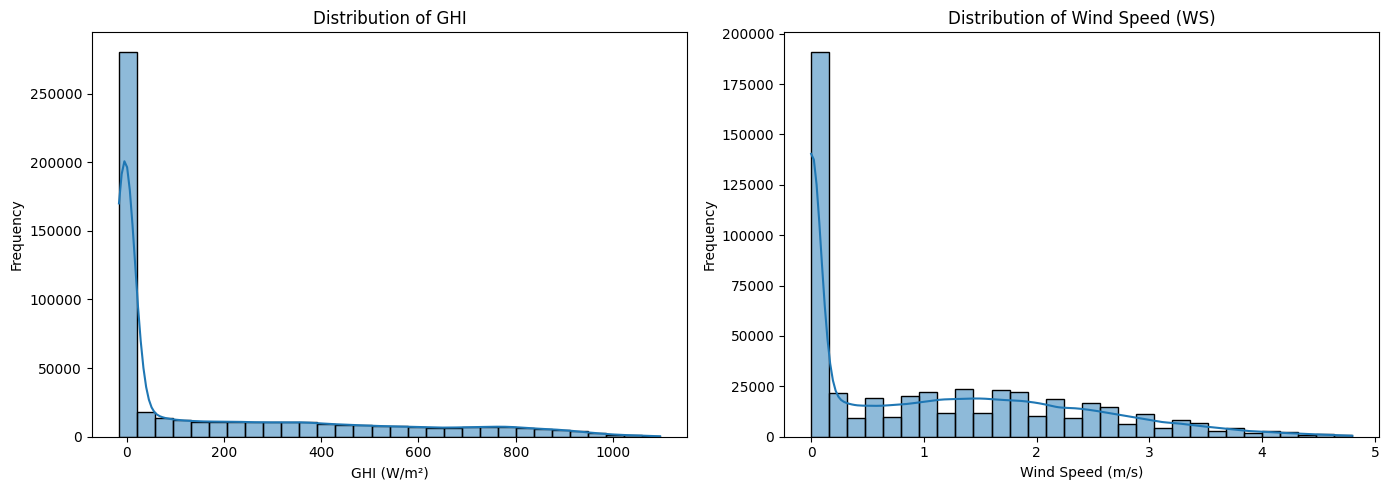

In [17]:
plot_histograms(df_clean)

**What the data shows:**
- Histograms show a large number of zero or low-irradiance periods (nighttime), with daytime values distributed across a range, peaking below the site’s maximum potential. The distribution is right-skewed, with rare high-irradiance events.

**Key understanding:**
- The variability in solar resource must be considered in system sizing and storage planning.

### 7.8 Temperature & Humidity Analysis

Analyze the interaction between ambient temperature and relative humidity, with shading by GHI, to understand meteorological influences on solar output.

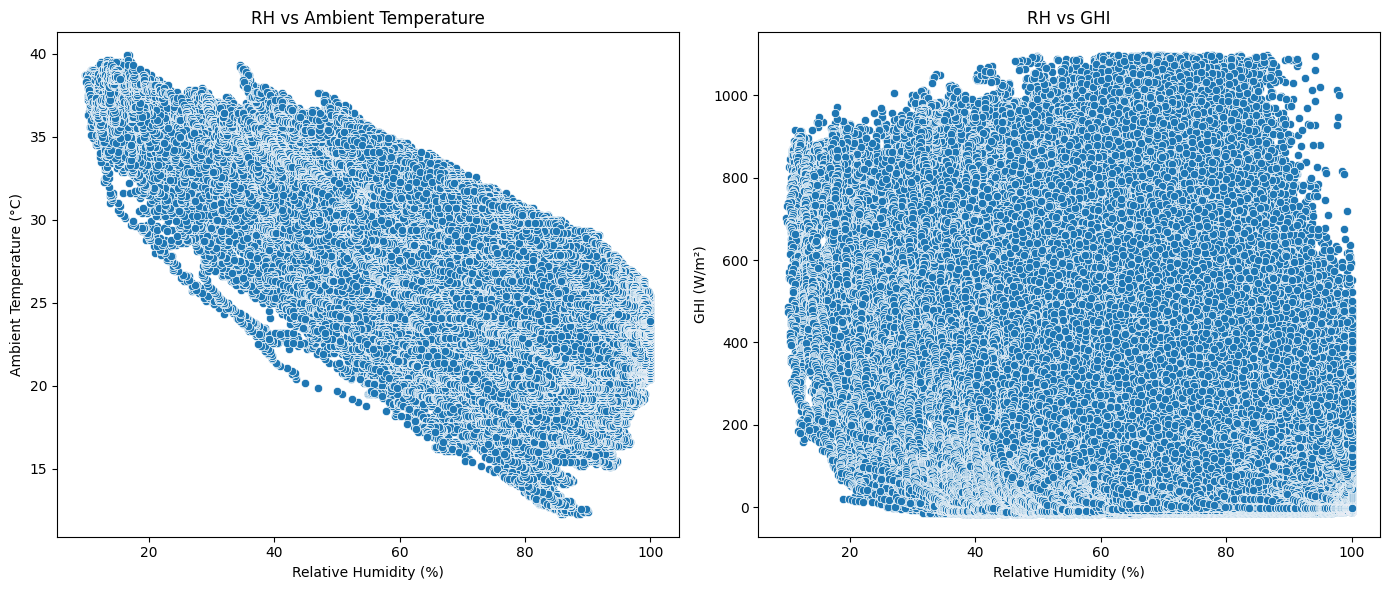

In [18]:
plot_temperature_analysis(df_clean)

**What the data shows:**
- The temperature and humidity analysis reveals that high GHI values are concentrated at moderate-to-high temperatures and low humidity. High humidity generally coincides with lower irradiance, while cooler temperatures span a wide range of humidity but rarely align with high GHI.

**Key understanding:**
- Humidity is a key limiting factor for solar output at the Bumbuna site.

### 7.9 Bubble Chart: GHI vs. Temperature with Humidity

Visualize GHI against ambient temperature, with bubble size representing relative humidity, to capture how solar irradiance varies with temperature and humidity.

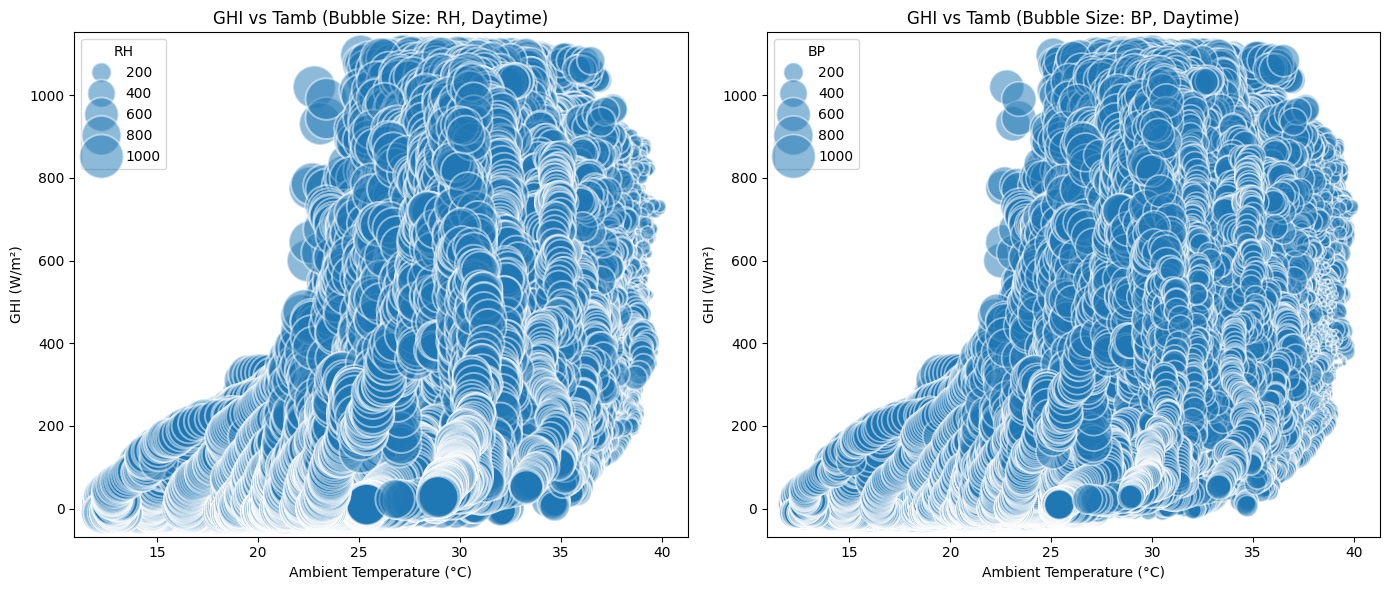

In [19]:
plot_bubble_chart(df_daytime)

**What the data shows:**
- The bubble chart shows that high GHI is most common on hot, dry days (small bubbles), while high humidity (large bubbles) is associated with low GHI, regardless of temperature.

**Key understanding:**
- Including humidity in forecasting models is crucial for accurate solar resource prediction in Sierra Leone.

# Full Analysis Summary

## Key Insights
- **Strong midday solar resource:** Sierra Leone’s Bumbuna site offers reliable and high midday solar irradiance, supporting solar farm development.
- **Seasonal variability:** Solar output drops significantly during the rainy season, requiring system and storage planning.
- **Soiling losses are substantial:** Regular panel cleaning can recover lost output, making maintenance a high-impact operational lever.
- **Humidity as a predictor:** High humidity is consistently linked to low solar output, making it a valuable forecasting variable.
- **Prevailing wind patterns:** Dominant wind directions affect both cooling and soiling, influencing design and maintenance.
- **Correlated variables:** Many variables are strongly correlated, allowing for model simplification but requiring care to avoid redundancy.

## Conclusion
Sierra Leone’s solar resource at Bumbuna is abundant but subject to seasonal and weather-driven variability. Addressing soiling, humidity, and wind effects can maximize yield and reliability.

## Recommendations
- **Optimize cleaning schedules:** Implement regular or automated cleaning to minimize soiling losses.
- **Plan for seasonality:** Size systems and storage to accommodate rainy season dips; align project timelines with dry season peaks.
- **Leverage weather forecasts:** Use humidity and wind data in operational models to anticipate low-output periods and adjust dispatch or maintenance accordingly.
- **Design for wind and dust:** Engineer mounts and infrastructure to withstand prevailing winds and minimize soiling from dust transport.
- **Simplify models where possible:** Use key predictors (GHI, humidity, wind) to streamline forecasting and control systems, avoiding unnecessary complexity from highly correlated variables.